# Lab 04
Jakub Mieszczak (jmieszczak@student.agh.edu.pl)

## Advection-diffusion equation


The solution involves both analytical and numerical approaches.

Analytical solution: Based on a shifted and decaying sine wave, this solution reflects the behavior of a diffusing and advecting initial profile in a bounded domain.

Numerical solution: Using an explicit finite difference method, the upwind scheme is applied for advection and central differencing for diffusion. The upwind method treats as u, combining diffusion and advection components, with the Courant number calculated at each step.

Comparison: The analytical and numerical solutions are compared through a vector graphic plot.



**1. diffusion PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   

Transport of $\color{green}\psi$ due to diffusion with consant coefficient $\color{orange}\mu$ can be modelled with the diffusion equation:
$$ \partial_{\color{red} t} {\color{green}\psi} - {\color{orange}\mu} \partial^2_{\color{blue}x}{\color{green}\psi}= 0 $$

For the special case of domain of length $L$ and initial condition ${\color{green}\psi}({\color{red} t}=0,{\color{blue}x}) = \sin(\pi {\color{blue}x} / L)$, an analytical solution is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=e^{-\mu (\pi/L)^2 {\color{red} t}} \sin(\pi {\color{blue}x} / L)$$

Let's depict the problem using NumPy and matplotlib:

In [3]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim

In [4]:
def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

In [5]:
class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

In [6]:
class Analytical_solution:
    def __init__(self, *, velocity, diffusivity):
        self.velocity = velocity
        self.diffusivity = diffusivity

    def __call__(self, position, time):
        return np.exp(-(np.square(self.velocity) / (4 * self.diffusivity) + np.square(np.pi) * self.diffusivity) * time) * np.sin(np.pi * position)

In [7]:
class DiscreteSolution:
    def __init__(self, *, max_time, velocity, diffusivity, num_steps, step_size):
        self.shift = shift(add=1, sub=1)
        self.half_shift = shift(add=0, sub=1)
        self.velocity = velocity
        self.num_steps = num_steps
        self.step_time = max_time / num_steps
        self.diffusivity = diffusivity
        self.step_space = step_size
        self.analytical_solution = Analytical_solution(velocity=self.velocity, diffusivity=self.diffusivity)

    def __call__(self, position):
        initial_conditions = self.analytical_solution(position, 0)
        coef = np.zeros(len(initial_conditions) - 1)
        num_points = len(position)
        middle_points = slice(1, num_points - 1)
        last_points = slice(1, num_points)

        for step in range(self.num_steps):
            coef[last_points - self.half_shift] = self.step_time / self.step_space * (self.velocity - self.diffusivity * (initial_conditions[last_points] - initial_conditions[last_points - self.shift]) / self.step_space * 2 / (initial_conditions[last_points] + initial_conditions[last_points - self.shift]))
            assert max(abs(coef)) <= 1
            initial_conditions[middle_points] = initial_conditions[middle_points] - (F(initial_conditions[middle_points], initial_conditions[middle_points + self.shift], coef[middle_points + self.half_shift]) - F(initial_conditions[middle_points - self.shift], initial_conditions[middle_points], coef[middle_points - self.half_shift]))

        return initial_conditions

In [8]:
def RelativeError(true_values, predicted_values):
    return np.sum(abs(true_values[1:-1] - predicted_values[1:-1]) / abs(true_values[1:-1])) / len(true_values[1:-1])

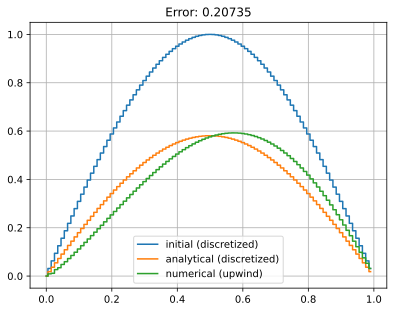

In [9]:
dx = 0.01
x = np.arange(0, 1, dx)
t_max = 5
solution = DiscreteSolution(max_time=t_max, velocity=.02, diffusivity=.01, num_steps=1450, step_size=dx)


def plot(time, positions=x, solution=solution):
    true_values = solution.analytical_solution(positions, time)
    predicted_values = solution(positions)
    fig = pyplot.figure()
    pyplot.step(positions, solution.analytical_solution(positions, 0), label='initial (discretized)', where='mid')
    pyplot.step(positions, true_values, label='analytical (discretized)', where='mid')
    pyplot.step(positions, predicted_values, label=f'numerical (upwind)', where='mid')
    pyplot.title(f"Error: {round(RelativeError(true_values, predicted_values),5)}")
    pyplot.legend()
    pyplot.grid()

    return fig

fig = plot(t_max, x, solution)
show_plot(fig=fig)


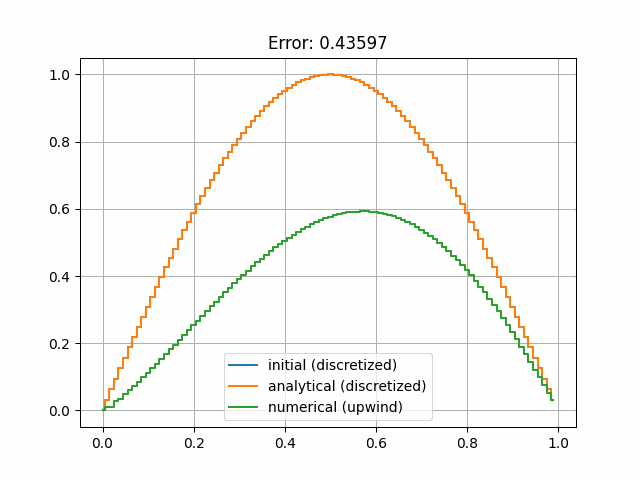

Button(description='tmpdaudwrsm.gif', style=ButtonStyle())

In [10]:
show_anim(plot, range(0, 40, 1))